Preprocessing....
1. Reads images and labels from the Kaggle dataset.
2. Creates a stratified subset (10% of the full dataset).
3. Splits that subset into train and test sets (90% / 10%).
4. Saves them as CSV files in the project.

In [23]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
dataset_dir1 = '../dataset/TB_Chest_Radiography_Database'

image_paths = []
labels = []

#function to process the directory
def process_directory(directory, label_list, path_list):
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for image_name in os.listdir(label_dir):
                if image_name.endswith('.jpg') or image_name.endswith('.png'):
                    image_path = os.path.join(label_dir, image_name)
                    path_list.append(image_path)
                    label_list.append(label)

process_directory(dataset_dir1, labels, image_paths)
data = {'Image_Path': image_paths, 'Label': labels}
df = pd.DataFrame(data)

# Calculate the subset size which is 10.00% of the total data
subset_size = int(0.1000 * len(df))

# Calculate the subset size which is 10.00% of the total data
subset_size = int(0.1000 * len(df))

# Split the data to get 10.00% of the entire dataset
_, subset_df = train_test_split(df, train_size=subset_size, stratify=df['Label'], random_state=42)

# Further split the subset into train and validation sets
train_df, test_df = train_test_split(subset_df, test_size=0.1, stratify=subset_df['Label'], random_state=42)
test_df['Label'] = "Unknown"

#saving the csv file
train_csv_path = '../dataset/train_data.csv'
test_csv_path = '../dataset/test_data.csv'

train_df.to_csv(train_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)

print("CSV files for train and validation data saved successfully!")

CSV files for train and validation data saved successfully!


In [24]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Image preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Pretrained models
from tensorflow.keras.applications import (
    Xception,
    DenseNet121,
    MobileNetV2,
    ResNet50V2,
    InceptionV3
)

# Layers, models, optimizers
from tensorflow.keras import layers, models, optimizers

# Splitting strategy
from sklearn.model_selection import StratifiedShuffleSplit

# Callbacks
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau,
    ModelCheckpoint
)

# Additional layers
from tensorflow.keras.layers import (
    Dropout,
    GlobalAveragePooling2D
)

# Sequential model
from tensorflow.keras.models import Sequential

This section loads the `train_data.csv` file containing the image paths and labels for the TB chest X-ray dataset.  
A **stratified train–validation split** is performed to maintain equal class distribution across both sets.

Next, data augmentation is applied to the training images to improve model robustness, while validation images are only rescaled.  
Finally, two data generators are created to read images from disk, preprocess them to **224×224**, and feed them into the model during training.

In [25]:
# Load the dataset

df = pd.read_csv('../dataset/train_data.csv')

# Ensure we have 17 unique classes
num_classes = len(df['Label'].unique())
print(num_classes)

# Define the stratified shuffle split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

# Perform the split
for train_index, val_index in split.split(df, df['Label']):
    train_df = df.iloc[train_index]
    val_df = df.iloc[val_index]

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32
target_size = (224, 224)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    x_col='Image_Path',
                                                    y_col='Label',
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(dataframe=val_df,
                                                        x_col='Image_Path',
                                                        y_col='Label',
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical')


2
Found 3061 validated image filenames belonging to 2 classes.
Found 341 validated image filenames belonging to 2 classes.


Perfroming EDA

In [26]:
# Understand the dataset
print(train_df.head())
print(train_df.shape)
print(train_df.info())
print(train_df.describe())

                                             Image_Path         Label
1986  ../dataset/TB_Chest_Radiography_Database\Tuber...  Tuberculosis
257   ../dataset/TB_Chest_Radiography_Database\Tuber...  Tuberculosis
1708  ../dataset/TB_Chest_Radiography_Database\Norma...        Normal
3368  ../dataset/TB_Chest_Radiography_Database\Norma...        Normal
646   ../dataset/TB_Chest_Radiography_Database\Norma...        Normal
(3061, 2)
<class 'pandas.core.frame.DataFrame'>
Index: 3061 entries, 1986 to 1008
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image_Path  3061 non-null   object
 1   Label       3061 non-null   object
dtypes: object(2)
memory usage: 71.7+ KB
None
                                               Image_Path   Label
count                                                3061    3061
unique                                               3061       2
top     ../dataset/TB_Chest_Radiography_Database\Norma...  Nor

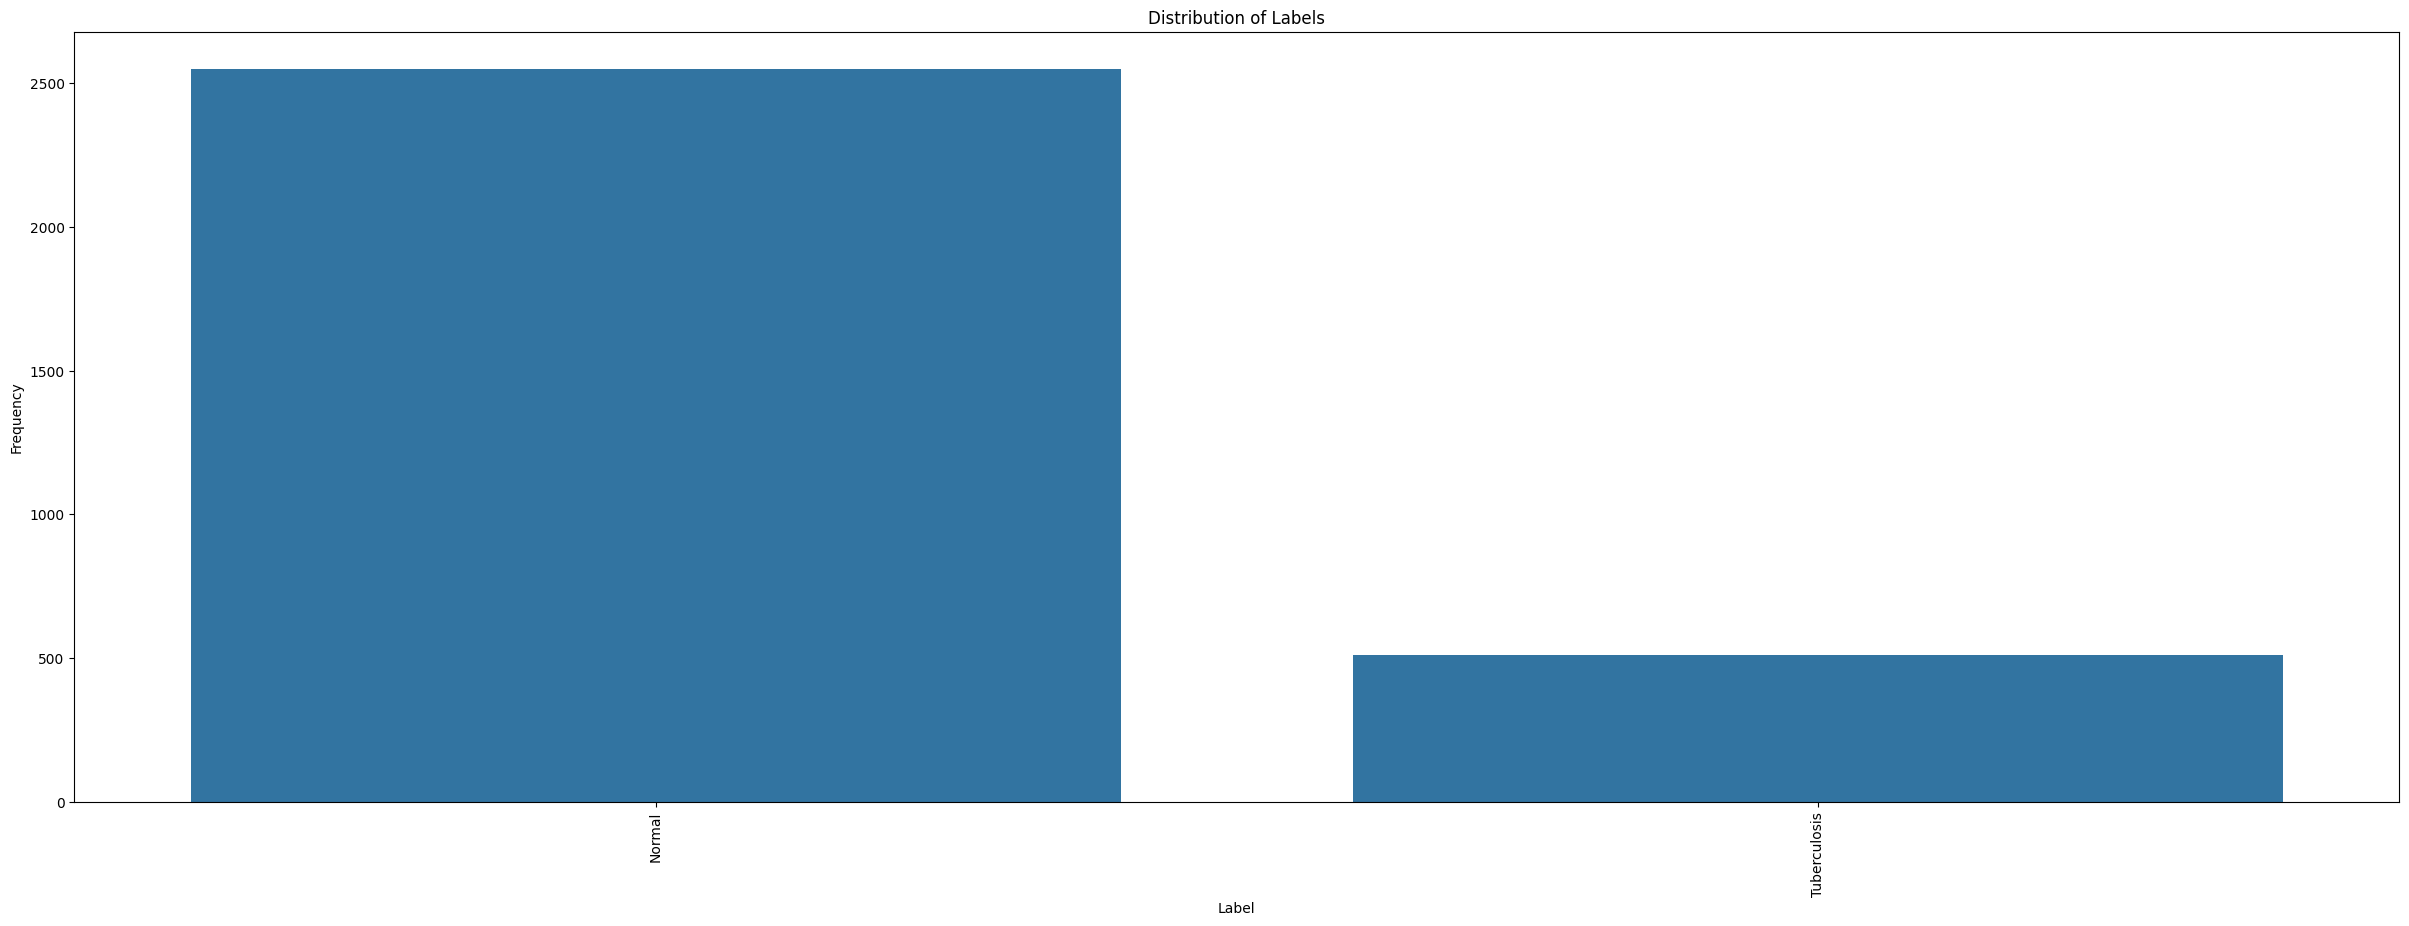

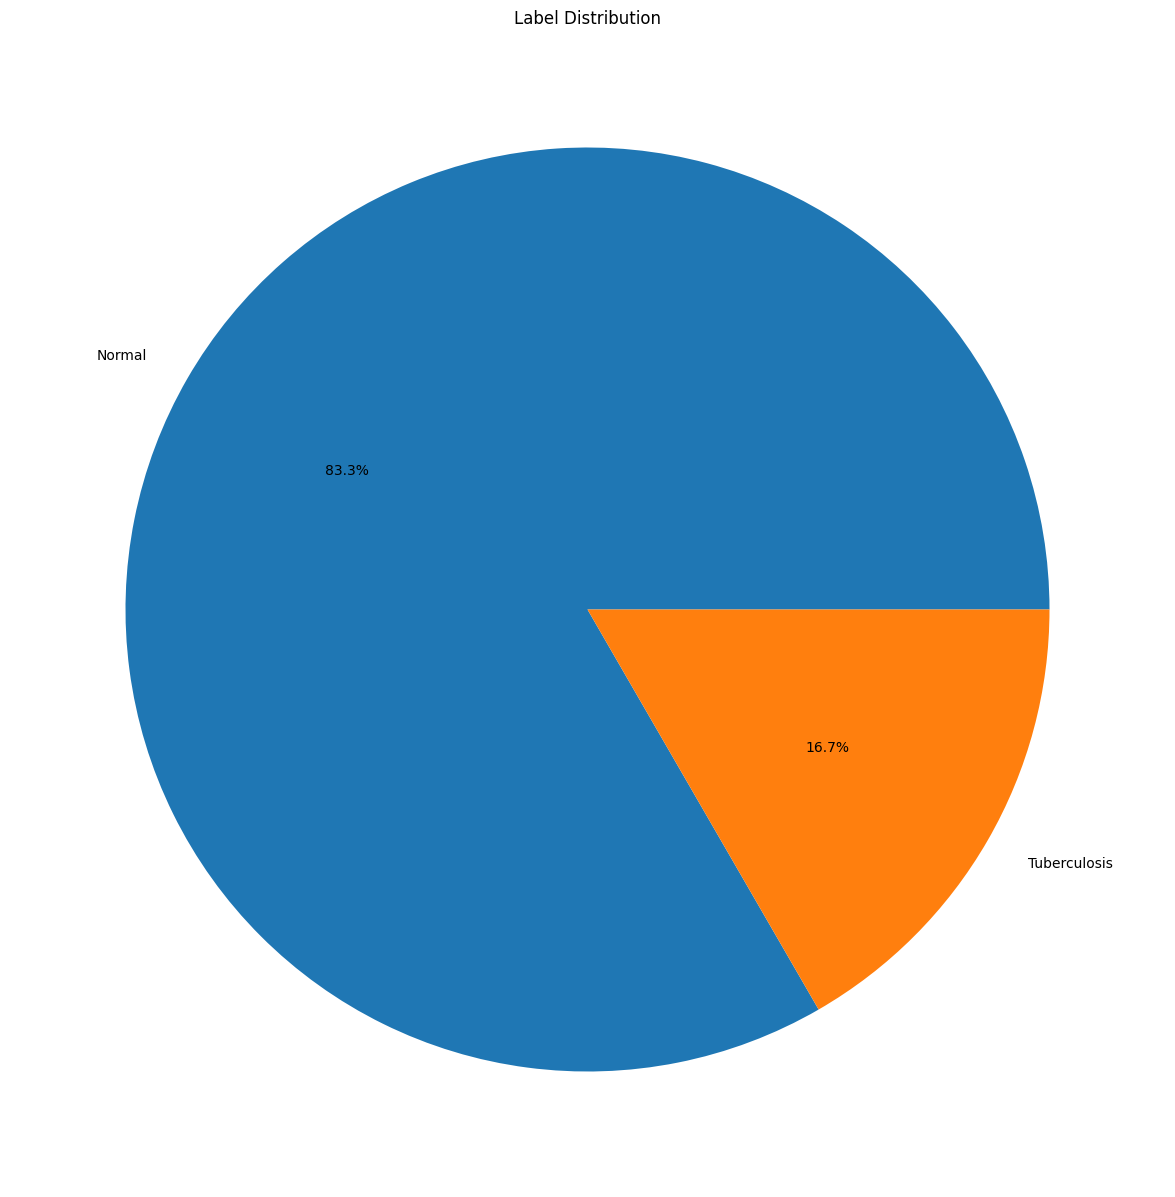

In [27]:
# Bar chart for label distribution
plt.figure(figsize=(30, 10))
sns.countplot(data=train_df, x='Label', order=train_df['Label'].value_counts().index)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate x labels for better readability
plt.show()

# Pie chart for label distribution
plt.figure(figsize=(15, 15))
train_df['Label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Label Distribution')
plt.ylabel('')  # Hide the y-label
plt.show()

Number of unique image paths: 3061


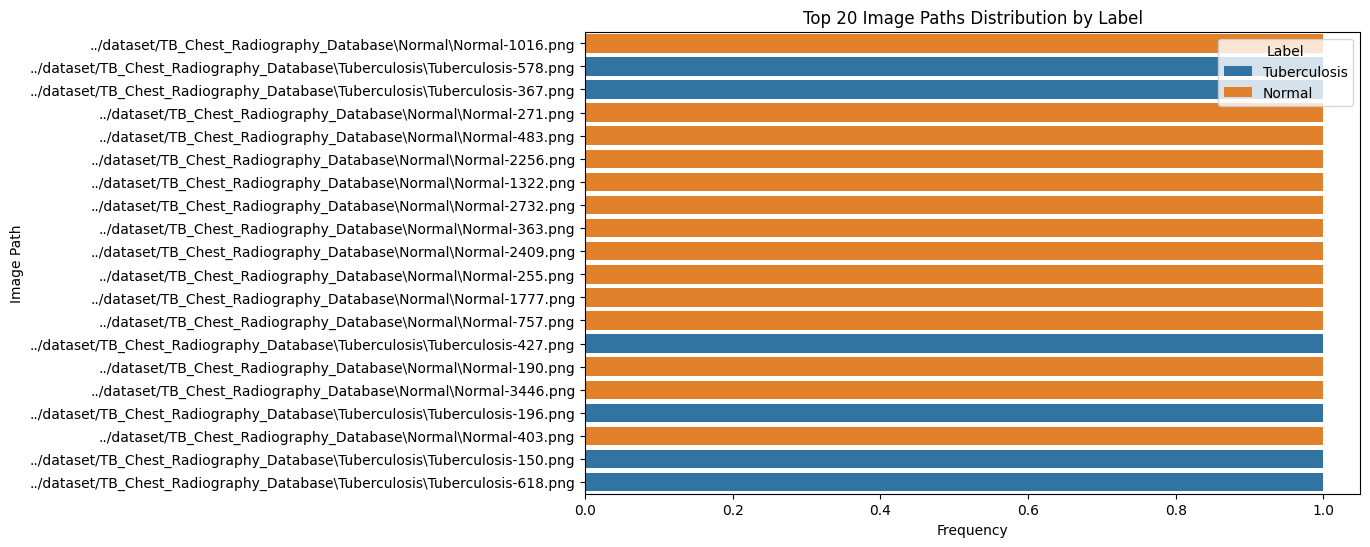

Column Image_Path has 3061 unique values.
Column Label has 2 unique values.


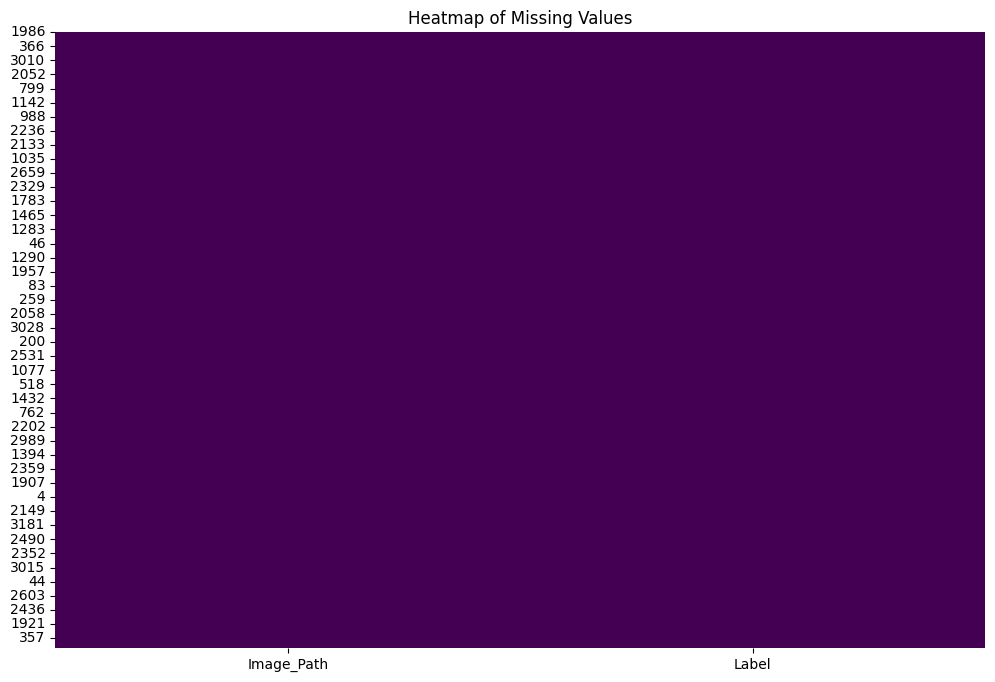

Label
Normal          2551
Tuberculosis     510
Name: count, dtype: int64


In [28]:
# Count unique image paths
unique_paths = train_df['Image_Path'].nunique()
print(f"Number of unique image paths: {unique_paths}")

# Image paths distribution by label (top 20 paths for readability)
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, y='Image_Path', hue='Label', order=train_df['Image_Path'].value_counts().index[:20])
plt.title('Top 20 Image Paths Distribution by Label')
plt.xlabel('Frequency')
plt.ylabel('Image Path')
plt.show()

# Unique values for each categorical column
for column in train_df.select_dtypes(include=['object']).columns:
    unique_values = train_df[column].nunique()
    print(f"Column {column} has {unique_values} unique values.")

# Missing values heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.show()

# Label counts summary
label_counts = train_df['Label'].value_counts()
print(label_counts)

In [29]:
# Data Cleaning
print(train_df.isnull().sum())
train_df.fillna(method='ffill', inplace=True)
print(train_df.duplicated().sum())
train_df.drop_duplicates(inplace=True)

Image_Path    0
Label         0
dtype: int64
0


C:\Users\Dell\AppData\Local\Temp\ipykernel_10128\2160291088.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df.fillna(method='ffill', inplace=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_10128\2160291088.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.fillna(method='ffill', inplace=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_10128\2160291088.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop_duplicates(inplace=True)


This function builds a transfer learning–based classification model for chest X-ray images.  
A pretrained CNN (e.g., DenseNet121, MobileNetV2, ResNet50V2) is passed as `base_model` and **kept frozen** during initial training to preserve its learned features.

On top of the base model, a custom classification head is added:

- **GlobalAveragePooling2D** to convert feature maps into a single feature vector  
- **Dense(512)** with ReLU activation  
- **Dropout(0.5)** to reduce overfitting  
- **Dense(256)** with ReLU  
- **Dropout(0.5)**  
- **Dense(num_classes)** with softmax for final class probabilities  

This architecture helps the model learn high-level TB-related patterns while avoiding overfitting on a relatively small dataset.

In [30]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential

def create_model(base_model, num_classes):
    # Freeze the pretrained backbone initially
    base_model.trainable = False  
    
    # Build the final classification model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model


This function handles the complete pipeline for training and evaluating a transfer learning model

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import numpy as np

def train_and_evaluate(model, train_data, val_data, model_name, epochs=10):
    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    checkpoint = ModelCheckpoint(filepath=f'{model_name}_best_model.h5',
                                monitor='val_loss',
                                save_best_only=True)

    # Train the model
    history = model.fit(
        train_data,
        validation_data=val_data,
        steps_per_epoch=len(train_data),
        epochs=epochs,
        callbacks=[early_stopping, reduce_lr, checkpoint]
    )

    # Load the best model weights
    model.load_weights(f'{model_name}_best_model.h5')

    # Evaluate on validation data
    val_loss, val_accuracy = model.evaluate(val_data)
    print(f'{model_name} Validation Accuracy: {val_accuracy:.4f}')

    # Plot accuracy curves
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.title(f'{model_name} Accuracy')
    plt.show()

    # Confusion Matrix
    val_data.reset()
    Y_pred = model.predict(val_data)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = val_data.classes

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=val_data.class_indices.keys())
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    return history


This function trains multiple pretrained CNN architectures (e.g., Xception, DenseNet121, MobileNetV2) using the `create_model()` and `train_and_evaluate()` functions.

In [11]:
def model_training(base_models):
    # Directory where final (non–best) models are saved
    save_dir = 'saved_models'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    histories = {}

    # Train and evaluate each base model
    for base_model, input_shape, model_name in base_models:
        model = create_model(base_model, num_classes)

        print(f'Training {model_name}...')
        history = train_and_evaluate(model, train_generator, validation_generator, model_name, epochs=10)
        histories[model_name] = history

        # Save final model again (optional, but allowed)
        model.save(os.path.join(save_dir, f'{model_name}_saved.h5'))
        print(f'Saved {model_name} model to {save_dir}/{model_name}_saved.h5')

    return histories


Loading the base models 

Training MobileNetV2...
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7858 - loss: 0.5225

96/96 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.8566 - loss: 0.3687 - val_accuracy: 0.8915 - val_loss: 0.2392 - learning_rate: 1.0000e-04
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.9334 - loss: 0.1742

96/96 ━━━━━━━━━━━━━━━━━━━━ 54s 563ms/step - accuracy: 0.9402 - loss: 0.1574 - val_accuracy: 0.9150 - val_loss: 0.1954 - learning_rate: 1.0000e-04
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 54s 561ms/step - accuracy: 0.9618 - loss: 0.1038 - val_accuracy: 0.9208 - val_loss: 0.2122 - learning_rate: 1.0000e-04
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 53s 550ms/step - accuracy: 0.9696 - loss: 0.0913 - val_accuracy: 0.9208 - val_loss: 0.2043 - learning_rate: 1.0000e-04
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.9720 - loss: 0.0747

96/96 ━━━━━━━━━━━━━━━━━━━━ 54s 561ms/step - accuracy: 0.9726 - loss: 0.0800 - val_accuracy: 0.9355 - val_loss: 0.1395 - learning_rate: 1.0000e-04
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 54s 560ms/step - accuracy: 0.9775 - loss: 0.0730 - val_accuracy: 0.9267 - val_loss: 0.2130 - learning_rate: 1.0000e-04
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 53s 557ms/step - accuracy: 0.9739 - loss: 0.0684 - val_accuracy: 0.9326 - val_loss: 0.1693 - learning_rate: 1.0000e-04
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 54s 557ms/step - accuracy: 0.9781 - loss: 0.0683 - val_accuracy: 0.9238 - val_loss: 0.2126 - learning_rate: 1.0000e-04
Epoch 9/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 54s 558ms/step - accuracy: 0.9771 - loss: 0.0631 - val_accuracy: 0.9267 - val_loss: 0.2022 - learning_rate: 2.0000e-05
Epoch 10/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 53s 556ms/step - accuracy: 0.9784 - loss: 0.0629 - val_accuracy: 0.9267 - val_loss: 0.1949 - learning_rate: 2.0000e-05
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 287ms/step - accuracy: 0.9355 - loss: 

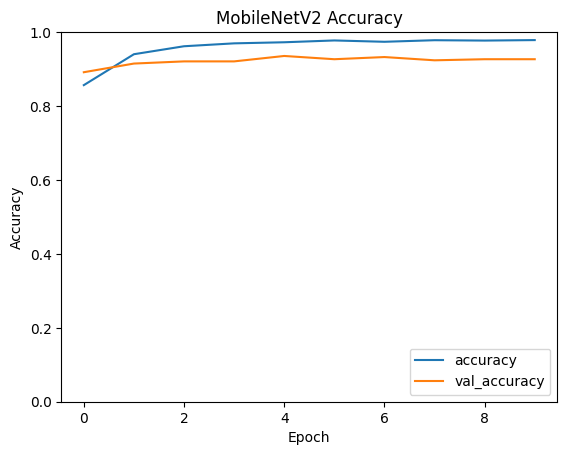

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 357ms/step


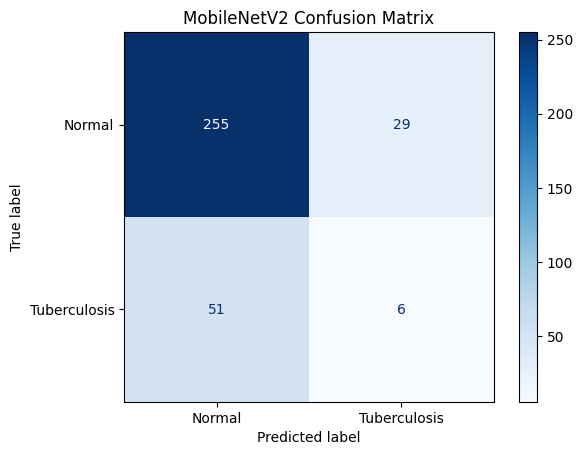

Saved MobileNetV2 model to saved_models/MobileNetV2_saved.h5


{'MobileNetV2': <keras.src.callbacks.history.History at 0x22f4b392e30>}

In [11]:
# List of base models with their respective input shapes
base_models1 = [ #mobilenet base model
    (
        MobileNetV2(
            weights='imagenet',
            include_top=False,
            input_shape=(224, 224, 3)
        ),
        (224, 224, 3),
        'MobileNetV2'
    ),
]

# Train using the selected base model
model_training(base_models1)

# Train InceptionV3

Training InceptionV3...
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.8066 - loss: 0.5222

96/96 ━━━━━━━━━━━━━━━━━━━━ 69s 665ms/step - accuracy: 0.8474 - loss: 0.4098 - val_accuracy: 0.9120 - val_loss: 0.1985 - learning_rate: 1.0000e-04
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.9057 - loss: 0.2550

96/96 ━━━━━━━━━━━━━━━━━━━━ 63s 655ms/step - accuracy: 0.9121 - loss: 0.2347 - val_accuracy: 0.9560 - val_loss: 0.1270 - learning_rate: 1.0000e-04
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.9195 - loss: 0.2223

96/96 ━━━━━━━━━━━━━━━━━━━━ 58s 607ms/step - accuracy: 0.9203 - loss: 0.2077 - val_accuracy: 0.9648 - val_loss: 0.1127 - learning_rate: 1.0000e-04
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 61s 636ms/step - accuracy: 0.9337 - loss: 0.1717 - val_accuracy: 0.9531 - val_loss: 0.1185 - learning_rate: 1.0000e-04
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.9376 - loss: 0.1726

96/96 ━━━━━━━━━━━━━━━━━━━━ 60s 618ms/step - accuracy: 0.9422 - loss: 0.1690 - val_accuracy: 0.9648 - val_loss: 0.1000 - learning_rate: 1.0000e-04
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.9490 - loss: 0.1489

96/96 ━━━━━━━━━━━━━━━━━━━━ 57s 594ms/step - accuracy: 0.9461 - loss: 0.1516 - val_accuracy: 0.9736 - val_loss: 0.0937 - learning_rate: 1.0000e-04
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.9601 - loss: 0.1300

96/96 ━━━━━━━━━━━━━━━━━━━━ 58s 603ms/step - accuracy: 0.9575 - loss: 0.1368 - val_accuracy: 0.9795 - val_loss: 0.0819 - learning_rate: 1.0000e-04
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 57s 591ms/step - accuracy: 0.9510 - loss: 0.1374 - val_accuracy: 0.9707 - val_loss: 0.0864 - learning_rate: 1.0000e-04
Epoch 9/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 56s 584ms/step - accuracy: 0.9487 - loss: 0.1371 - val_accuracy: 0.9765 - val_loss: 0.0821 - learning_rate: 1.0000e-04
Epoch 10/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.9527 - loss: 0.1259

96/96 ━━━━━━━━━━━━━━━━━━━━ 57s 592ms/step - accuracy: 0.9582 - loss: 0.1159 - val_accuracy: 0.9736 - val_loss: 0.0774 - learning_rate: 1.0000e-04
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 317ms/step - accuracy: 0.9736 - loss: 0.0774
InceptionV3 Validation Accuracy: 0.9736


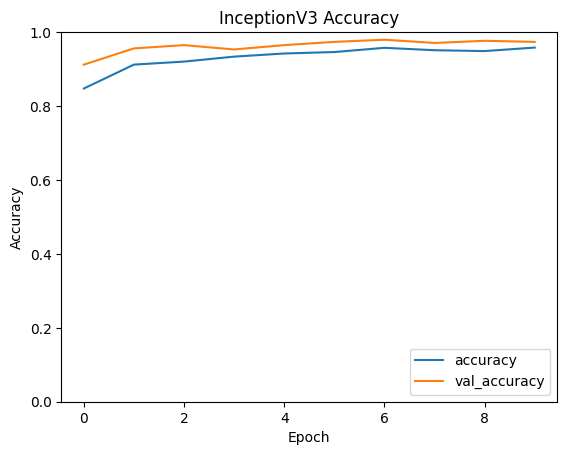

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 464ms/step


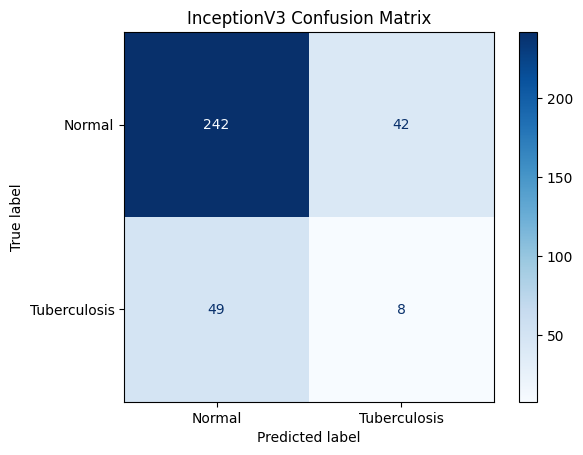

Saved InceptionV3 model to saved_models/InceptionV3_saved.h5


{'InceptionV3': <keras.src.callbacks.history.History at 0x22f95322830>}

In [13]:
base_models2 = [
    (
        InceptionV3(
            weights='imagenet',
            include_top=False,
            input_shape=(224, 224, 3)
        ),
        (299, 299, 3),
        'InceptionV3'
    )
]


model_training(base_models2)

# Train Xception model

Training Xception...
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - accuracy: 0.8291 - loss: 0.4058

96/96 ━━━━━━━━━━━━━━━━━━━━ 92s 921ms/step - accuracy: 0.8759 - loss: 0.3244 - val_accuracy: 0.9208 - val_loss: 0.2271 - learning_rate: 1.0000e-04
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 89s 926ms/step - accuracy: 0.9177 - loss: 0.2100 - val_accuracy: 0.9267 - val_loss: 0.2326 - learning_rate: 1.0000e-04
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 858ms/step - accuracy: 0.9238 - loss: 0.1980

96/96 ━━━━━━━━━━━━━━━━━━━━ 90s 936ms/step - accuracy: 0.9334 - loss: 0.1723 - val_accuracy: 0.9384 - val_loss: 0.1821 - learning_rate: 1.0000e-04
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.9497 - loss: 0.1456

96/96 ━━━━━━━━━━━━━━━━━━━━ 87s 902ms/step - accuracy: 0.9409 - loss: 0.1590 - val_accuracy: 0.9443 - val_loss: 0.1564 - learning_rate: 1.0000e-04
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 87s 901ms/step - accuracy: 0.9471 - loss: 0.1357 - val_accuracy: 0.9443 - val_loss: 0.1659 - learning_rate: 1.0000e-04
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.9475 - loss: 0.1367

96/96 ━━━━━━━━━━━━━━━━━━━━ 86s 896ms/step - accuracy: 0.9490 - loss: 0.1360 - val_accuracy: 0.9443 - val_loss: 0.1551 - learning_rate: 1.0000e-04
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - accuracy: 0.9560 - loss: 0.1224

96/96 ━━━━━━━━━━━━━━━━━━━━ 85s 882ms/step - accuracy: 0.9575 - loss: 0.1184 - val_accuracy: 0.9472 - val_loss: 0.1415 - learning_rate: 1.0000e-04
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.9566 - loss: 0.1399

96/96 ━━━━━━━━━━━━━━━━━━━━ 85s 880ms/step - accuracy: 0.9628 - loss: 0.1231 - val_accuracy: 0.9531 - val_loss: 0.1310 - learning_rate: 1.0000e-04
Epoch 9/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.9612 - loss: 0.1076

96/96 ━━━━━━━━━━━━━━━━━━━━ 85s 879ms/step - accuracy: 0.9628 - loss: 0.1070 - val_accuracy: 0.9531 - val_loss: 0.1242 - learning_rate: 1.0000e-04
Epoch 10/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 83s 857ms/step - accuracy: 0.9588 - loss: 0.1052 - val_accuracy: 0.9443 - val_loss: 0.1656 - learning_rate: 1.0000e-04
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 605ms/step - accuracy: 0.9531 - loss: 0.1242
Xception Validation Accuracy: 0.9531


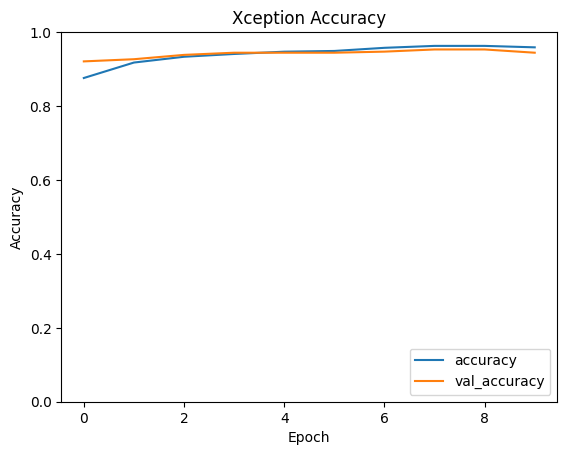

11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 661ms/step


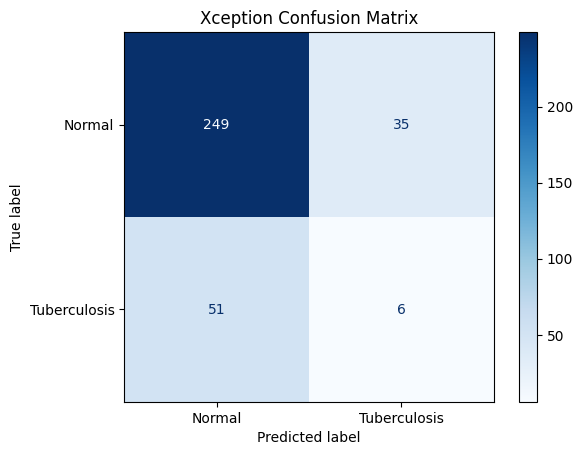

Saved Xception model to saved_models/Xception_saved.h5


{'Xception': <keras.src.callbacks.history.History at 0x22f96bee9b0>}

In [14]:

base_models3 = [
    (
        Xception(
            weights='imagenet',
            include_top=False,
            input_shape=(224,224, 3)
        ),
        (299, 299, 3),
        'Xception'
    )
]


model_training(base_models3)


# Train ResNet50V2 model

Training ResNet50V2...
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.8079 - loss: 0.4742

96/96 ━━━━━━━━━━━━━━━━━━━━ 73s 714ms/step - accuracy: 0.8595 - loss: 0.3579 - val_accuracy: 0.9355 - val_loss: 0.1521 - learning_rate: 1.0000e-04
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.9209 - loss: 0.2069

96/96 ━━━━━━━━━━━━━━━━━━━━ 67s 700ms/step - accuracy: 0.9301 - loss: 0.1901 - val_accuracy: 0.9472 - val_loss: 0.1278 - learning_rate: 1.0000e-04
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.9416 - loss: 0.1542

96/96 ━━━━━━━━━━━━━━━━━━━━ 66s 689ms/step - accuracy: 0.9454 - loss: 0.1468 - val_accuracy: 0.9648 - val_loss: 0.1010 - learning_rate: 1.0000e-04
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 66s 683ms/step - accuracy: 0.9539 - loss: 0.1205 - val_accuracy: 0.9619 - val_loss: 0.1088 - learning_rate: 1.0000e-04
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.9597 - loss: 0.1117

96/96 ━━━━━━━━━━━━━━━━━━━━ 66s 691ms/step - accuracy: 0.9592 - loss: 0.1126 - val_accuracy: 0.9707 - val_loss: 0.0920 - learning_rate: 1.0000e-04
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 66s 685ms/step - accuracy: 0.9621 - loss: 0.1047 - val_accuracy: 0.9648 - val_loss: 0.1112 - learning_rate: 1.0000e-04
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 66s 685ms/step - accuracy: 0.9615 - loss: 0.0992 - val_accuracy: 0.9677 - val_loss: 0.1094 - learning_rate: 1.0000e-04
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.9678 - loss: 0.1059

96/96 ━━━━━━━━━━━━━━━━━━━━ 66s 690ms/step - accuracy: 0.9726 - loss: 0.0863 - val_accuracy: 0.9677 - val_loss: 0.0918 - learning_rate: 1.0000e-04
Epoch 9/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 66s 686ms/step - accuracy: 0.9667 - loss: 0.0843 - val_accuracy: 0.9648 - val_loss: 0.1017 - learning_rate: 1.0000e-04
Epoch 10/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 66s 683ms/step - accuracy: 0.9722 - loss: 0.0826 - val_accuracy: 0.9648 - val_loss: 0.0972 - learning_rate: 1.0000e-04
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 396ms/step - accuracy: 0.9677 - loss: 0.0918
ResNet50V2 Validation Accuracy: 0.9677


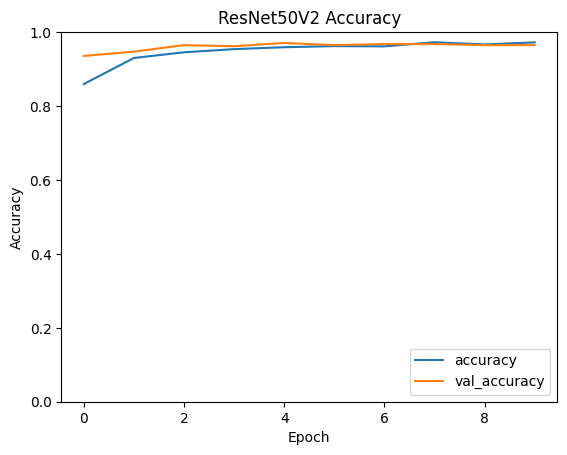

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 499ms/step


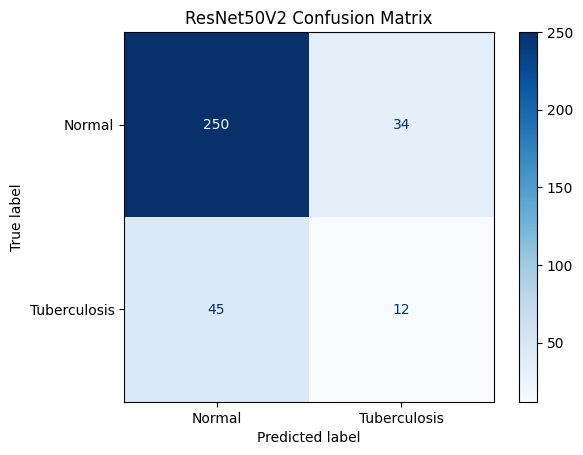

Saved ResNet50V2 model to saved_models/ResNet50V2_saved.h5


{'ResNet50V2': <keras.src.callbacks.history.History at 0x22fda8ffc10>}

In [16]:
base_models4 = [
    (
        ResNet50V2(
            weights='imagenet',
            include_top=False,
            input_shape=(224, 224, 3)
        ),
        (224, 224, 3),
        'ResNet50V2'
    )
]


model_training(base_models4)

# Train DenseNet121

Training DenseNet121...
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.7936 - loss: 0.5437

96/96 ━━━━━━━━━━━━━━━━━━━━ 95s 898ms/step - accuracy: 0.8321 - loss: 0.4422 - val_accuracy: 0.9003 - val_loss: 0.2318 - learning_rate: 1.0000e-04
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.8793 - loss: 0.2876

96/96 ━━━━━━━━━━━━━━━━━━━━ 83s 865ms/step - accuracy: 0.8906 - loss: 0.2630 - val_accuracy: 0.9355 - val_loss: 0.1821 - learning_rate: 1.0000e-04
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 83s 858ms/step - accuracy: 0.9203 - loss: 0.2009 - val_accuracy: 0.9413 - val_loss: 0.1847 - learning_rate: 1.0000e-04
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.9209 - loss: 0.1975

96/96 ━━━━━━━━━━━━━━━━━━━━ 83s 865ms/step - accuracy: 0.9258 - loss: 0.1896 - val_accuracy: 0.9443 - val_loss: 0.1532 - learning_rate: 1.0000e-04
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.9387 - loss: 0.1711

96/96 ━━━━━━━━━━━━━━━━━━━━ 83s 866ms/step - accuracy: 0.9415 - loss: 0.1589 - val_accuracy: 0.9472 - val_loss: 0.1315 - learning_rate: 1.0000e-04
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.9575 - loss: 0.1103

96/96 ━━━━━━━━━━━━━━━━━━━━ 83s 865ms/step - accuracy: 0.9526 - loss: 0.1263 - val_accuracy: 0.9531 - val_loss: 0.1160 - learning_rate: 1.0000e-04
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - accuracy: 0.9545 - loss: 0.1357

96/96 ━━━━━━━━━━━━━━━━━━━━ 83s 867ms/step - accuracy: 0.9546 - loss: 0.1326 - val_accuracy: 0.9648 - val_loss: 0.0970 - learning_rate: 1.0000e-04
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 83s 862ms/step - accuracy: 0.9598 - loss: 0.1075 - val_accuracy: 0.9589 - val_loss: 0.1004 - learning_rate: 1.0000e-04
Epoch 9/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 83s 864ms/step - accuracy: 0.9582 - loss: 0.1187 - val_accuracy: 0.9648 - val_loss: 0.1007 - learning_rate: 1.0000e-04
Epoch 10/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 83s 861ms/step - accuracy: 0.9624 - loss: 0.1022 - val_accuracy: 0.9501 - val_loss: 0.1322 - learning_rate: 1.0000e-04
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 583ms/step - accuracy: 0.9648 - loss: 0.0970
DenseNet121 Validation Accuracy: 0.9648


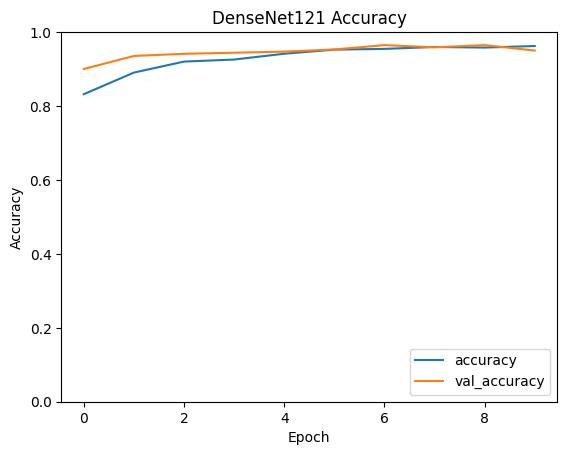

11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 820ms/step


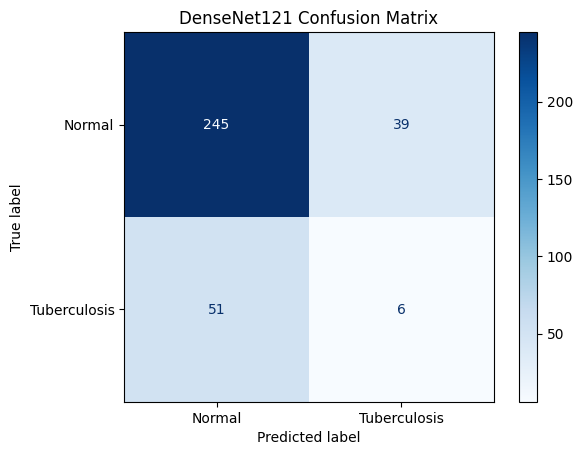

Saved DenseNet121 model to saved_models/DenseNet121_saved.h5


{'DenseNet121': <keras.src.callbacks.history.History at 0x22fb484ee90>}

In [15]:
base_models5 = [
    (
        DenseNet121(
            weights='imagenet',
            include_top=False,
            input_shape=(224, 224, 3)
        ),
        (224, 224, 3),
        'DenseNet121'
    )
]

model_training(base_models5)

Testing unlabelled data 

In [48]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image


test_df = pd.read_csv('../dataset/test_data.csv')

# Load class indices (from train_generator used during training)
class_indices_inverse = {v: k for k, v in train_generator.class_indices.items()}

# Directory containing the saved models (relative to models/ folder)
model_dir = 'saved_models'
prediction_labels=['Normal','Tuberculosis']
# Define batch size
batch_size = 32

# Function to process images in batches
def process_images_in_batches(image_paths, model, target_size, batch_size):
    num_images = len(image_paths)
    num_batches = (num_images + batch_size - 1) // batch_size  # number of batches

    all_predictions = []

    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, num_images)
        batch_paths = image_paths[start_idx:end_idx]

        batch_images = []
        for img_path in batch_paths:
            img = image.load_img(img_path, target_size=target_size)
            img = image.img_to_array(img)
            img = img / 255.0
            batch_images.append(img)

        batch_images = np.array(batch_images)
        batch_predictions_probs = model.predict(batch_images)
        batch_predictions = np.argmax(batch_predictions_probs, axis=1)

        all_predictions.extend(batch_predictions)

    return all_predictions

# Iterate over each model file in the saved_models directory
for model_file in os.listdir(model_dir):
    if model_file.endswith('.h5'):
        # Load the model
        model_path = os.path.join(model_dir, model_file)
        model = load_model(model_path)

        # Determine target size based on model name
       
        target_size = (224, 224)

        # Process images in batches and make predictions
        image_paths = test_df['Image_Path'].tolist()
        prediction = process_images_in_batches(image_paths, model, target_size, batch_size)

        # Map predictions to class labels
        prediction_labels = [class_indices_inverse[label] for label in prediction]

        # Create a DataFrame with predictions
        predicted_df = pd.DataFrame({
            'Image_Path': test_df['Image_Path'],
            'Label': prediction_labels,
        })

        # Save predictions to CSV in saved_models/ folder
        csv_path = os.path.join(model_dir, f'predicted_{model_file.split(".")[0]}.csv')
        predicted_df.to_csv(csv_path, header=True, index=False)

        print(f"Predictions saved to {csv_path}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predictions saved to saved_models\predicted_DenseNet121_saved.csv


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predictions saved to saved_models\predicted_InceptionV3_saved.csv


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predictions saved to saved_models\predicted_MobileNetV2_saved.csv


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predictions saved to saved_models\predicted_ResNet50V2_saved.csv


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predictions saved to saved_models\predicted_Xception_saved.csv


Image label prediction and visualization (the image has been showcased)

In [50]:
import pandas as pd

pred_df = pd.read_csv('saved_models/predicted_MobileNetV2_saved.csv')  # or any predicted_* csv
print(pred_df['Image_Path'].head())
print(any(pred_df['Image_Path'] == '../dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-539.png'))


0    ../dataset/TB_Chest_Radiography_Database\Norma...
1    ../dataset/TB_Chest_Radiography_Database\Norma...
2    ../dataset/TB_Chest_Radiography_Database\Norma...
3    ../dataset/TB_Chest_Radiography_Database\Norma...
4    ../dataset/TB_Chest_Radiography_Database\Norma...
Name: Image_Path, dtype: object
False



📌 Predictions using: predicted_DenseNet121_saved


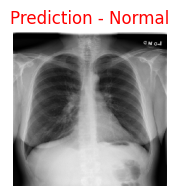

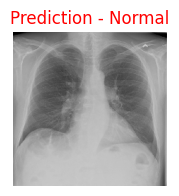

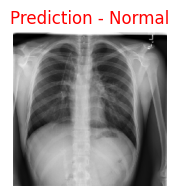

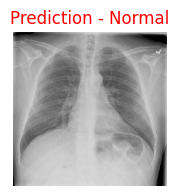

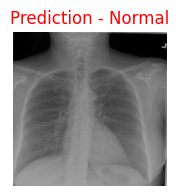


📌 Predictions using: predicted_InceptionV3_saved


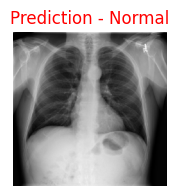

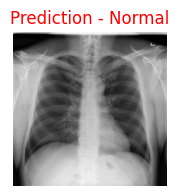

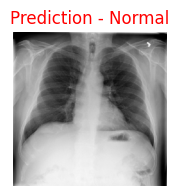

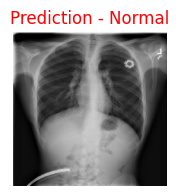

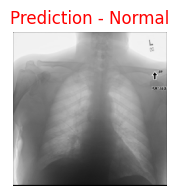


📌 Predictions using: predicted_MobileNetV2_saved


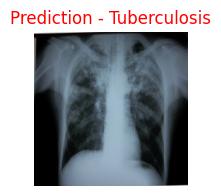

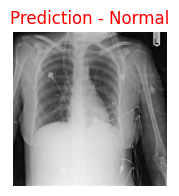

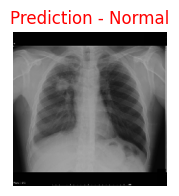

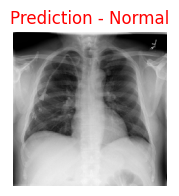

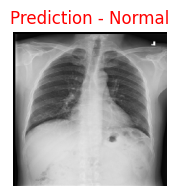


📌 Predictions using: predicted_ResNet50V2_saved


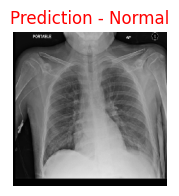

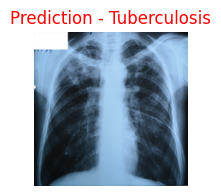

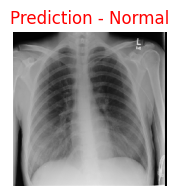

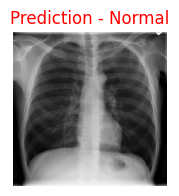

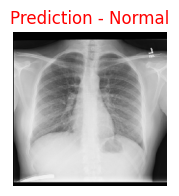


📌 Predictions using: predicted_Xception_saved


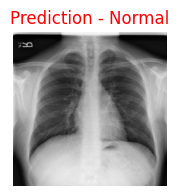

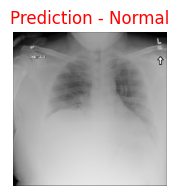

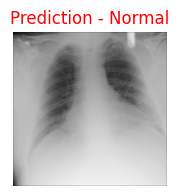

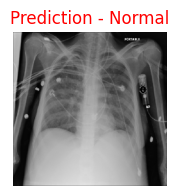

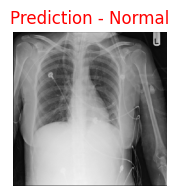

In [51]:
import csv
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Directory containing the predicted CSV files (inside models/)
csv_dir = 'saved_models'


def load_predicted_labels(csv_file_path):
    """Load image path -> predicted label from a prediction CSV."""
    predicted_labels = {}
    with open(csv_file_path, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            norm_path = row['Image_Path'].replace('\\', '/').strip()
            predicted_labels[norm_path] = row['Label']
    return predicted_labels


def visualize_predictions(predicted_labels, target_size=(224, 224), num_samples=5):
    """
    Randomly pick sample images from predicted_labels and display them.
    num_samples = 5 for showcasing.
    """
    all_paths = list(predicted_labels.keys())
    if not all_paths:
        print("No image paths found in prediction CSV.")
        return

    # Randomly pick 5 image paths (or less if fewer images)
    num_samples = min(num_samples, len(all_paths))
    sample_paths = random.sample(all_paths, num_samples)

    for img_path in sample_paths:
        img = image.load_img(img_path, target_size=target_size)
        img_array = image.img_to_array(img) / 255.0

        predicted_class_name = predicted_labels.get(img_path, "Unknown")

        plt.figure(figsize=(2, 2))
        plt.imshow(img_array)
        plt.title(f"Prediction - {predicted_class_name}", size=12, color='red')
        plt.axis('off')
        plt.show()


# Iterate over CSV files in saved_models/
for csv_file in os.listdir(csv_dir):
    if csv_file.startswith('predicted_') and csv_file.endswith('.csv'):

        model_name = csv_file.split('.')[0]
        predicted_csv_file = os.path.join(csv_dir, csv_file)

        print(f"\n📌 Predictions using: {model_name}")

        predicted_labels = load_predicted_labels(predicted_csv_file)

        # Choose target size based on model architecture
        if "Xception_saved" in model_name or "InceptionV3_saved" in model_name:
            target_size = (299, 299)
        else:
            target_size = (224, 224)

        # Show 5 images only
        visualize_predictions(predicted_labels, target_size=target_size, num_samples=5)
